# Project 2, Learning from Data

**Jonatan Haraldsson (jonhara) and Oscar Stommendal (oscarsto)**

In [6]:
# =========================================================================== #
# Library imports
# =========================================================================== #

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd
from keras.regularizers import L2
import pickle


In [7]:
# =========================================================================== #
# Settings setup along with variable and general functions definitions
# =========================================================================== #

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 36
plt.rcParams['font.size'] = font_size

In [8]:
# =========================================================================== #
# Basic Task
# =========================================================================== #

# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']


# Remove data where data[:, -1, 1:5] = 0, i.e.
# where the particles get stuck in (0, 0)
data = data[np.sum(data[:,-1,1:5], axis=1) != 0]

N,time_steps, variables = data.shape
# Rng
rng = np.random.default_rng(seed=19)
# rng.shuffle(data)


In [9]:
# =========================================================================== #
# Data preprocessing
# =========================================================================== #

# Split the data into training and validation sets
t_train = data[:int(N*0.9), :, 0]
x_2_train = data[:int(N*0.9),0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_train = data[:int(N*0.9),0,4].reshape(-1,1) @ np.ones((1, 1000))

t_val = data[-int(N*0.1)-1:, :, 0]
x_2_val = data[-int(N*0.1)-1:,0,3].reshape(-1,1) @ np.ones((1, 1000))
y_2_val = data[-int(N*0.1)-1:,0,4].reshape(-1,1) @ np.ones((1, 1000))

train_data = np.dstack((t_train, x_2_train, y_2_train))
val_data = np.dstack((t_val, x_2_val, y_2_val))

train_targets = data[:int(data.shape[0]*0.9), :, (1, 2, 3, 4)]
val_targets = data[-int(data.shape[0]*0.1)-1:, :, (1, 2, 3, 4)]

print(train_data.shape)
print(val_data.shape)

# Set batch sizes (number of data points per batch, should be int*1000)
batch_size_train = int(68e3)
batch_size_val = int(7e3)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size_train)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size_val)


(6860, 1000, 3)
(763, 1000, 3)


In [10]:
# =========================================================================== #
# Helping functions
# =========================================================================== #

def get_trajectories(pred, indx):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
        indx (int): Index of the trajectory to get. If None, all trajectories
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """

    if indx == None:
        # All trajectories
        x1 = pred[:,:,0];x2 = pred[:,:,2]
        x3 = -x2 - x1
        y1 = pred[:,:,1];y2 = pred[:,:,3]
        y3 = -y1 -y2
    else:
        # Single trajectory
        x1 = pred[indx,:,0];x2 = pred[indx,:,2]
        x3 = -x2 - x1
        y1 = pred[indx,:,1];y2 = pred[indx,:,3]
        y3 = -y1 -y2

    # Stack the x and y positions
    p1 = np.dstack((x1, y1))
    p2 = np.dstack((x2, y2))
    p3 = np.dstack((x3, y3))

    return p1, p2, p3 

def plot_trajectories(traject_model, traject_pre, traject_true,model, 
                        trajectory_number, ax=None, save_traj=False):
    """
    Plots trajectories for points p1, p2, p3 for the model, pre-trained model and true data.
    
    Args:
        traject_model (array): Trajectories from the model,
        traject_pre (array): Trajectories from the pre-trained model,
        traject_true (array): True trajectories,
        model (str): Name of the model,
        trajectory_number (int): Index of the trajectory to plot,
        ax (Axes object): Axes object to plot the trajectories,
        save_traj (bool): Boolean to determine whether to save the plot.
    
    Returns:
        ax: Axes object
    """

    # 
    fig, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)

    # Plot the trajectories from model
    p1, p2, p3 = get_trajectories(traject_model,trajectory_number)
    ax[0].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ {model}', **kwargs,color='tab:blue',linestyle='--')
    ax[0].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ {model}', **kwargs,color='tab:red',linestyle='--')
    ax[0].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ {model}', **kwargs,color='tab:green',linestyle='--')
    
    # Plot the trajectories from the true data
    p1, p2, p3 = get_trajectories(traject_true,trajectory_number)
    ax[0].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Target', **kwargs,color='tab:blue',alpha=0.5)
    ax[0].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Target', **kwargs,color='tab:red',alpha=0.5)
    ax[0].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Target', **kwargs,color='tab:green',alpha=0.5)

    # Plot the initial and final positions
    ax[0].plot(p1[0,0,0], p1[0,0,1], marker='o' , **kwargs,color='tab:blue',markersize=10)
    ax[0].plot(p2[0,0,0], p2[0,0,1], marker='o', **kwargs,color='tab:red',markersize=10)
    ax[0].plot(p3[0,0,0], p3[0,0,1], marker='o', **kwargs,color='tab:green',markersize=10)
    ax[0].plot(p1[0,-1,0], p1[0,-1,1], marker='s' , **kwargs,color='tab:blue',markersize=10)
    ax[0].plot(p2[0,-1,0], p2[0,-1,1], marker='s', **kwargs,color='tab:red',markersize=10)
    ax[0].plot(p3[0,-1,0], p3[0,-1,1], marker='s', **kwargs,color='tab:green',markersize=10)
    ax[0].legend()
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')

    # Plot the trajectories from pre-trained model
    p1, p2, p3 = get_trajectories(traject_pre,trajectory_number)
    ax[1].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Pre-trained', **kwargs,color='tab:blue',linestyle='--')
    ax[1].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Pre-trained', **kwargs,color='tab:red',linestyle='--')
    ax[1].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Pre-trained', **kwargs,color='tab:green',linestyle='--')
    
    # Plot the trajectories from the true data
    p1, p2, p3 = get_trajectories(traject_true,trajectory_number)
    ax[1].plot(p1[0,:,0], p1[0,:,1], label=f'$(x_1,y_1)$ Target', **kwargs,color='tab:blue',alpha=0.5)
    ax[1].plot(p2[0,:,0], p2[0,:,1], label=f'$(x_2,y_2)$ Target', **kwargs,color='tab:red',alpha=0.5)
    ax[1].plot(p3[0,:,0], p3[0,:,1], label=f'$(x_3,y_3)$ Target', **kwargs,color='tab:green',alpha=0.5)

    # Plot the initial and final positions
    ax[1].plot(p1[0,0,0], p1[0,0,1], marker='o' , **kwargs,color='tab:blue',markersize=10)
    ax[1].plot(p2[0,0,0], p2[0,0,1], marker='o', **kwargs,color='tab:red',markersize=10)
    ax[1].plot(p3[0,0,0], p3[0,0,1], marker='o', **kwargs,color='tab:green',markersize=10)
    ax[1].plot(p1[0,-1,0], p1[0,-1,1], marker='s' , **kwargs,color='tab:blue',markersize=10)
    ax[1].plot(p2[0,-1,0], p2[0,-1,1], marker='s', **kwargs,color='tab:red',markersize=10)
    ax[1].plot(p3[0,-1,0], p3[0,-1,1], marker='s', **kwargs,color='tab:green',markersize=10)
    ax[1].legend()

    ax[1].set_xlabel('$x$')
    ax[1].text(0.035,-1.5,'b)',fontsize = 28)
    ax[0].text(0.035,-1.5,'a)',fontsize = 28)    
    plt.tight_layout()

    if save_traj:
        plt.savefig(f'trajectories {trajectory_number} for {model}.pdf')    

    return ax

def plot_history(history,model_name, save_training_curves=False):

    ''' Function to plot the training curves of a model.
    Args:
        history: History of the model,
        model_name: Name of the model,
        save_training_curves: Boolean to determine whether to save the training curves.
    '''

    # Get the training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(train_loss, label='Training loss', color='tab:blue',lw = lw, marker='o',ms = 4)
    plt.plot(val_loss, label='Validation loss', color='k', linestyle='solid',lw=lw, marker='x',ms = 4,alpha=0.5)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if save_training_curves:
        plt.savefig(f'Training curve {model_name}.pdf')

def save_model(model, model_name):
    '''
    Function to save a model.

    Args:
        model: Keras model,
        model_name: Name of the model to save (can be a path).
    '''
    model.save(f'{model_name}.keras')

def training_models(model, epochs, train_data, val_data, earlystop=True, 
                    loss_function=keras.losses.MeanAbsoluteError(), 
                    metric='mean_absolute_error', learning_rate=0.002, patience=10):
    '''
    Function to train a model and return the history, model and time taken to train.

    Args:
        model: Keras model,
        epochs: Number of epochs to train the model,
        train_data: Training data,
        val_data: Validation data,
        earlystop: Boolean to determine whether to use early stopping,
        loss_function: Loss function to use,
        metric: Metric to use,
        learning_rate: Learning rate for the optimizer,
        patience: Patience for early stopping.
    
    Returns:
        history: Training history,
        model: Trained model,
        t: Time taken to train the model.
    '''

    # Compile the model
    model.compile(loss=loss_function,
            optimizer=tf.optimizers.Adam(learning_rate,0.75,0.99),
            metrics=[metric])
    
    # Early stopping
    if earlystop:
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min',restore_best_weights = True)
        # Start the timer
        start = time.time()
        # Fit the model
        history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping])
        end = time.time()
        t = end-start
        print(f'Time to run: {t:.1f}s')
    else:
        start = time.time()
        history = model.fit(train_data, epochs=epochs, validation_data=val_data)
        end = time.time()
        t = end-start
        print(f'Time to run: {t:.1f}s')
    
    return history, model, t

def prediction(model, targets,data):
    """Function to predict the trajectories of the 
        particles given the initial positions and the targets.
        
        Args:   
            model: Keras model,
            targets: Targets to predict,
            data: Initial positions of the particles.
        returns:   
            traject: Predicted trajectories."""
    

    traject = np.zeros((targets.shape))
    X_0 = np.array([1,0]).reshape(-1,1)
    Y_0 = np.ones((1,len(data[:])))
    init_pos_particle2 = (X_0 @ Y_0).T

    for time_step in range(targets.shape[1]):
        if time_step == 0:
            traject[:,time_step,:] = np.concatenate((init_pos_particle2,data[:,time_step,1:]),axis=1)
        else:
            traject[:,time_step,:] = model.predict(data[:,time_step,:],verbose=0)
            
    return traject

def init_dist_data(val_data,tr_num,t_train,val_targets):

    """Function for initializing the data for the disturbed trajectories
    Args:
        val_data: Validation data,
        tr_num: Trajectory number to disturb,
        t_train: Time steps,
        val_targets: Validation targets.
    Returns:
        val_dist: Disturbed validation data,
        val_data_init_true: True initial data,
        val_tar_dist: Disturbed targets"""

    val_data_init_true = val_data[tr_num,0,:][1:].reshape(-1,1) @ np.ones((1,100))
    t_dist = t_train[:100,:]
    rng = np.random.default_rng(seed=19)
    phi = rng.uniform(0, 2*np.pi, size = 100)
    r = 0.01 * np.array([np.cos(phi), np.sin(phi)])
    val_dist_x = (val_data_init_true[0] + r[0]).reshape(-1,1)
    val_dist_y = (val_data_init_true[1] + r[1]).reshape(-1,1)

    val_dist = np.dstack((t_dist, val_dist_x@ np.ones((1, 1000)), val_dist_y@ np.ones((1, 1000))))

    val_tar_dist = val_targets[tr_num,:,:]
    val_tar_dist = np.tile(val_tar_dist, (100, 1, 1))

    return val_dist, val_data_init_true,val_tar_dist

def dist_plotter(true_dist_traj,dist_traj,pre_dist_traj,indx = None,t_steps = [1,250,500,750,1000],save_disturbed = False):

    """Function for plotting the disturbed trajectories
    Args: 
        true_dist_traj: True disturbed trajectories,
        dist_traj: Model disturbed trajectories,
        pre_dist_traj: Pre-trained disturbed trajectories,
        indx: Index of the trajectory to plot,
        t_steps: Time steps to plot,
        save_disturbed: Boolean to determine whether to save the plot.
    Returns:
        Plot of the disturbed trajectories."""

    # Get the trajectories
    _,p2_model,_ = get_trajectories(dist_traj,indx)
    _,p2_true,_ = get_trajectories(true_dist_traj,indx)
    _,p2_pre,_ = get_trajectories(pre_dist_traj,indx)


    fig,ax = plt.subplots(1,2,figsize=(16,7),sharey=True)

    ax[0].plot(p2_model[:,:,0],p2_model[:,:,1],color = 'tab:blue',lw = 0.5,alpha = 0.075)
    ax[0].plot([],[],color='tab:blue',lw = 5,alpha = 0.5,label='Dense_10 pred.')
    ax[1].plot([],[],color='tab:blue',lw = 5,alpha = 0.5,label='Pre-trained pred.')
    
    # Plot trajectory values at the specified time steps
    for t in t_steps:
        if t == 1000:
            ax[0].plot(p2_model[:,t-1,0],p2_model[:,t-1,1],'o',ms = 2,color = 'blue',label = 'Dense_10 pred. at $t$',alpha = 0.8)
            ax[1].plot(p2_pre[:,t-1,0],p2_pre[:,t-1,1],'o',ms = 2,color = 'blue',label = 'Pre-trained pred. at $t$')
        else:
            ax[0].plot(p2_model[:,t-1,0],p2_model[:,t-1,1],'o',ms = 2,color = 'blue')
            ax[1].plot(p2_pre[:,t-1,0],p2_pre[:,t-1,1],'o',ms = 2,color = 'blue')


    ax[0].plot(p2_true[0,:,0],p2_true[0,:,1],color = 'k',linestyle = 'dashed',lw = 2,alpha = 0.5,label = 'True')
    ax[0].legend()
    
    ax[0].plot(p2_true[0,-1,0],p2_true[0,-1,1],'s',color = 'k',ms = 10,alpha = 0.7)
    
    ax[1].plot(p2_pre[:,:,0],p2_pre[:,:,1],color = 'tab:blue',lw = 0.5,alpha = 0.075)
    ax[1].plot(p2_true[0,:,0],p2_true[0,:,1],color = 'k',linestyle = 'dashed',lw = 2,alpha = 0.5,label = 'True')
    ax[1].legend()
    ax[1].plot(p2_true[0,-1,0],p2_true[0,-1,1],'s',color = 'k',ms = 10,alpha = 0.7)
    
    ax[1].text(-0.325,-.55,'b)',fontsize = 28)
    ax[1].set_xlabel('$x$')
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    ax[0].text(-0.325,-.55,'a)',fontsize = 28)
    
    ax[1].legend()
    plt.tight_layout()

    if save_disturbed:
        plt.savefig('Disturbed trajectories.pdf')
        

In [11]:
# =========================================================================== #
# Model definitions
# =========================================================================== #

# Load pre-trained model
pre_trained_model = keras.models.load_model('Breen_NN_project2.keras')
pre_trained_model.trainable = False
pre_trained_model.summary(show_trainable=True)

model_10_Dense = keras.models.Sequential([   
    keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4,activation='linear')
])

model_5_Dense = keras.models.Sequential([   
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])

model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.Conv1D(filters = 64, kernel_size = 1, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4)
])


lstm_model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(64,recurrent_regularizer=L2(0.01),return_sequences=True),input_shape=(3,1)),
    keras.layers.LSTM(32,return_sequences=False),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4)
])


mixed_model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 128, kernel_size = 3, activation='relu',input_shape=(3,1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=4)
])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_78 (Dense)            │ (None, 128)           │        512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_79 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_80 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_81 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_82 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_83 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_84 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_85 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_86 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_87 (Dense)            │ (None, 128)           │     16,512 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_88 (Dense)            │ (None, 4)             │        516 │   N   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 149,636 (1.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 149,636 (1.14 MB)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an 

In [12]:
# =========================================================================== #
# Model training
# =========================================================================== #

# Epochs
epochs = 10

# Use the training_models function to train the models

history_cnn, model_cnn, t_cnn = training_models(model_cnn, epochs, train_dataset, val_dataset, earlystop=True)
#history_lstm, model_lstm, t_lstm = training_models(lstm_model, epochs, train_dataset, val_dataset,earlystop=True)
#history_pre, model_pre, t_pre = training_models(pre_trained_model, epochs, 'mean_squared_error', 'mean_squared_error', 0.001, 10, train_dataset, val_dataset)
#history_5, model_5, t_5 = training_models(model_5_Dense, epochs, train_dataset, val_dataset, earlystop=True)
#history_10, model_10, t_10 = training_models(model_10_Dense, epochs, train_dataset, val_dataset, earlystop=True)
#history_mixed, model_mixed, t_mixed = training_models(mixed_model, epochs, train_dataset, val_dataset, earlystop=True)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.3374 - mean_absolute_error: 0.3374 - val_loss: 0.2135 - val_mean_absolute_error: 0.2135
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.1633 - val_mean_absolute_error: 0.1633
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.1627 - mean_absolute_error: 0.1627 - val_loss: 0.1499 - val_mean_absolute_error: 0.1499
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.1497 - mean_absolute_error: 0.1497 - val_loss: 0.1345 - val_mean_absolute_error: 0.1345
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.1382 - mean_absolute_error: 0.1382 - val_loss: 0.1275 - val_mean_absolute_error: 0.1275
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.1296 - mean_absolute_error: 0.1296 - val_loss: 0.1353 - val_mean_absolute_error: 0.1353
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.1264 - mean_absolute_error: 0.1

In [13]:
# Plot the training curves

#loss = model_10.evaluate(val_dataset)
#print(f'Loss: {loss}')

#with open('models/trainHistoryDict_10','rb') as file_pi:
    #history_10 = pickle.load(file_pi)

#plot_history(history_cnn, 'history_CNN1', save_training_curves = True)

#save_model(model_cnn,'model_CNN_1')

## Loading pre-saved models

In [14]:
# Load models for prediction and evaluation
model_5_dense = keras.models.load_model('models/model_5_Dense.keras')
model_10_dense = keras.models.load_model('models/model_10_Dense.keras')
model_cnn = keras.models.load_model('models/model_cnn.keras')
model_lstm = keras.models.load_model('model_lstm.keras')
model_mixed = keras.models.load_model('models/model_mixed.keras')

## Model Predictions

In [15]:
traject_dense_5 = prediction(model_5_dense, val_targets, val_data)

I0000 00:00:1730285291.692553  378682 service.cc:145] XLA service 0x2ced0fb10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730285291.692760  378682 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1730285291.883021  378682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
traject_10_dense = prediction(model_10_dense, val_targets, val_data)

In [17]:
traject_cnn = prediction(model_cnn, val_targets, val_data)

In [18]:
traject_lstm = prediction(model_lstm, val_targets, val_data)

In [19]:
traject_mixed = prediction(mixed_model, val_targets, val_data)

In [20]:
traject_pre = prediction(pre_trained_model, val_targets, val_data)

In [21]:
# Trajectory index
tr_num = 2

## Plotting trajectories

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

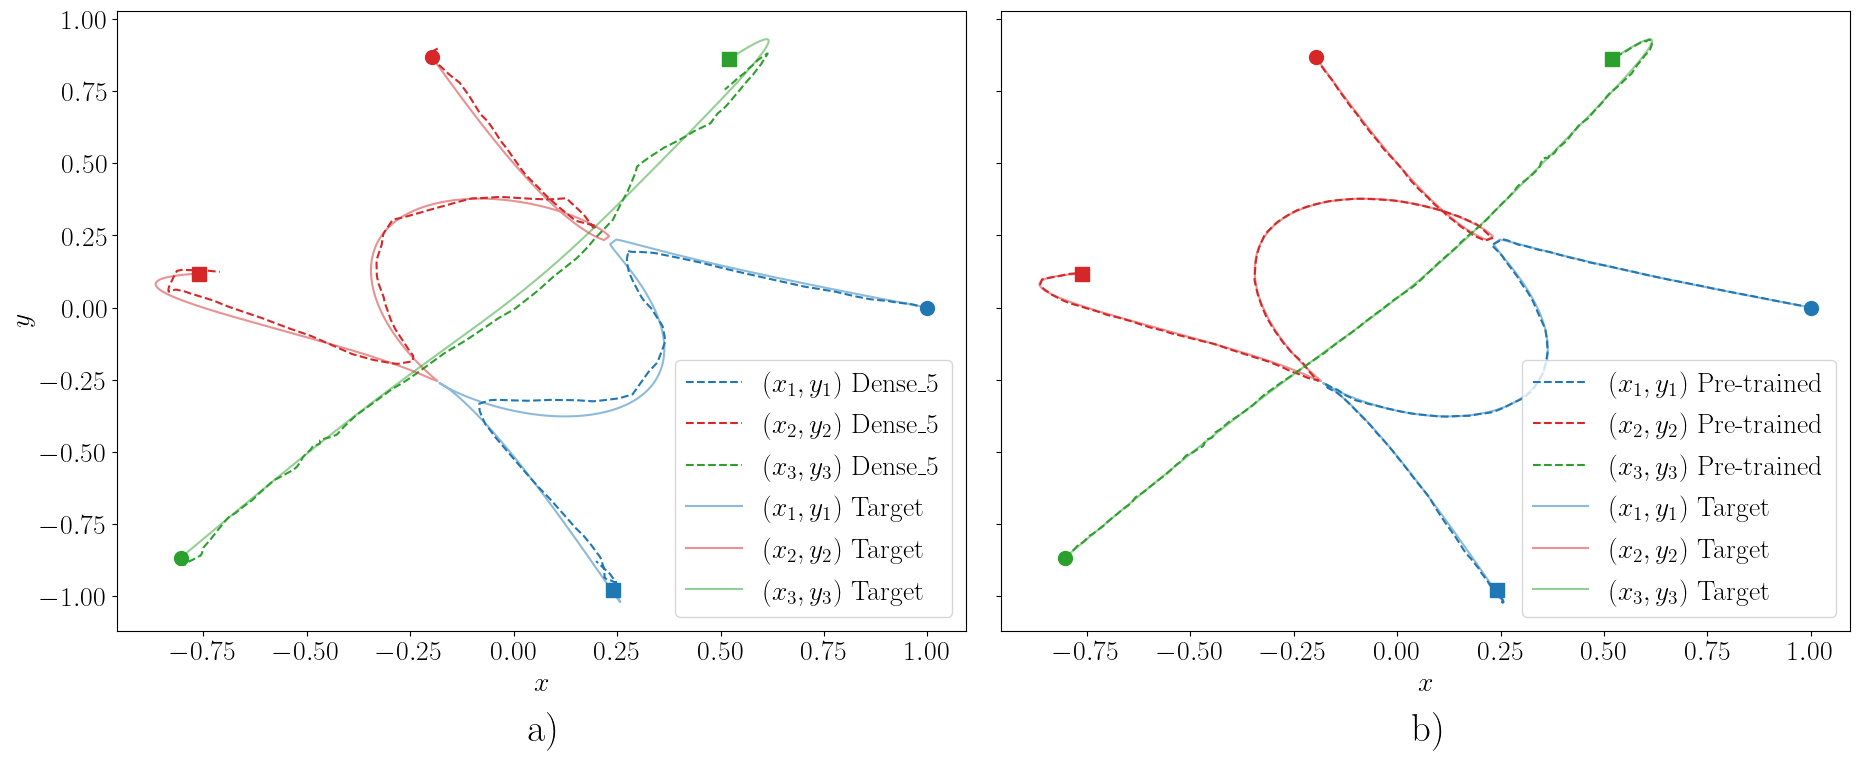

In [117]:
plot_trajectories(traject_dense_5,traject_pre, val_targets,
                model = 'Dense_5', trajectory_number=tr_num)


array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

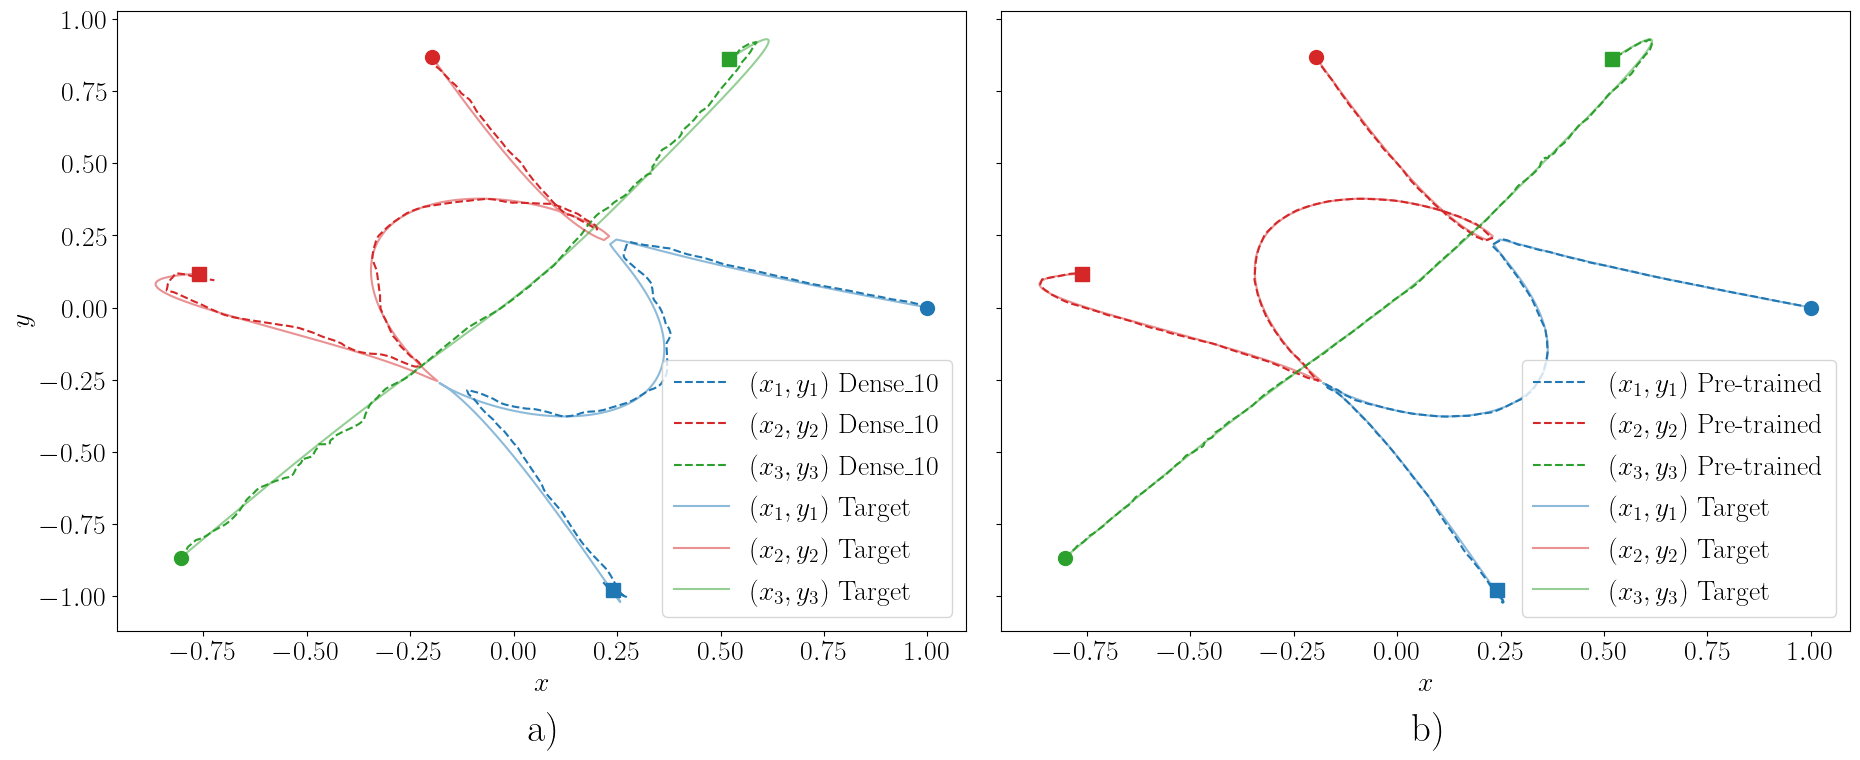

In [118]:
plot_trajectories(traject_10_dense,traject_pre, val_targets,
                model = 'Dense_10', trajectory_number=tr_num)

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

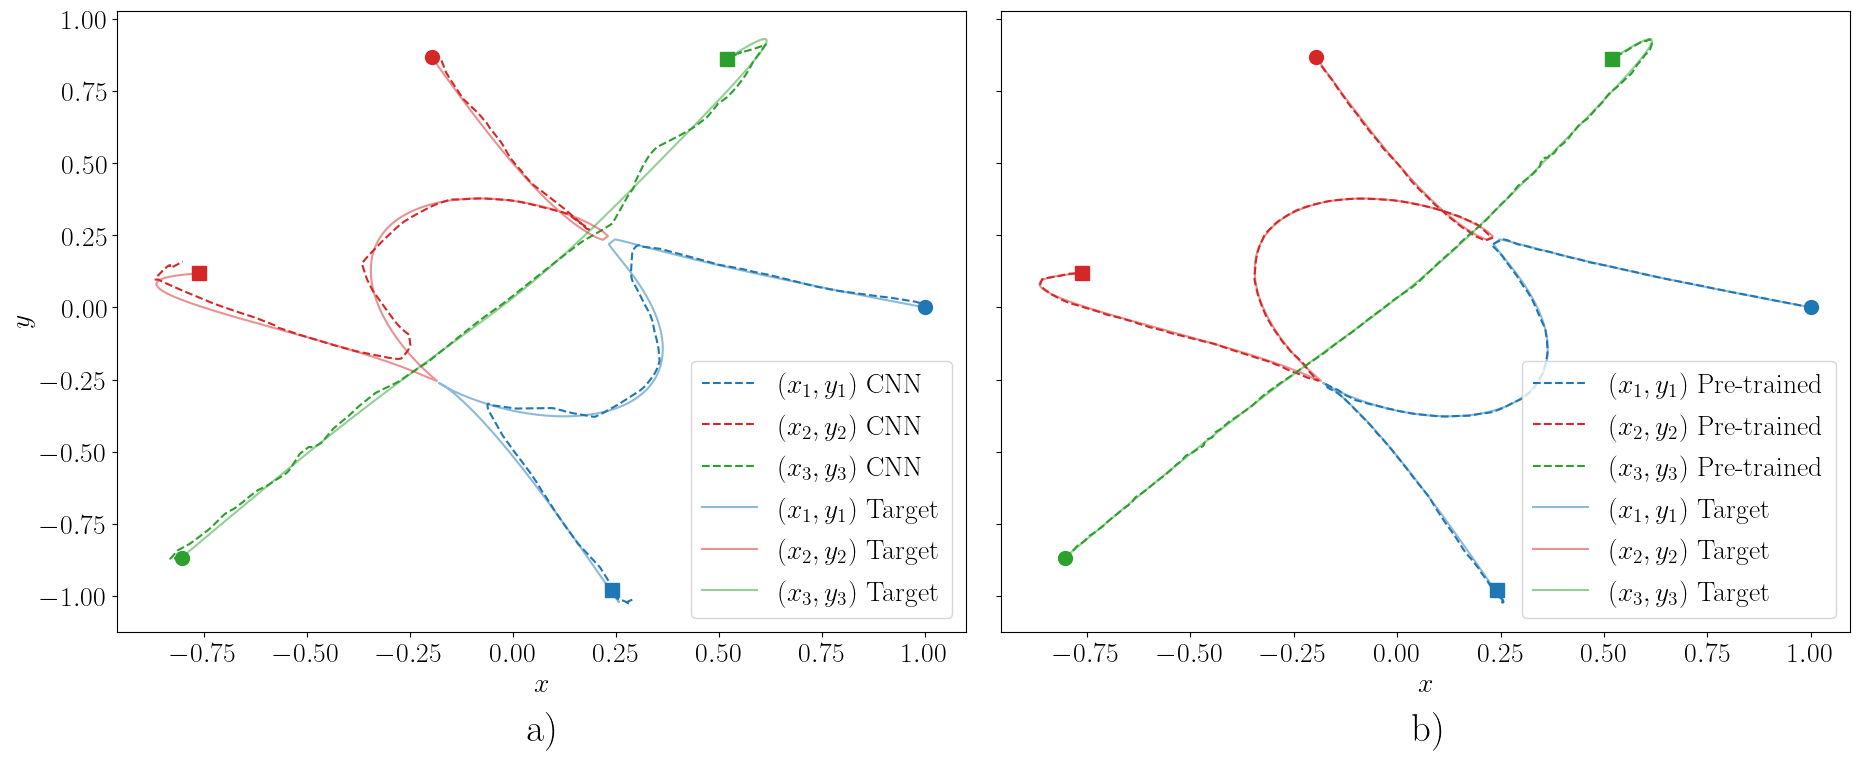

In [32]:
plot_trajectories(traject_cnn,traject_pre, val_targets,
               model = 'CNN', trajectory_number=tr_num,save_traj=True)

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

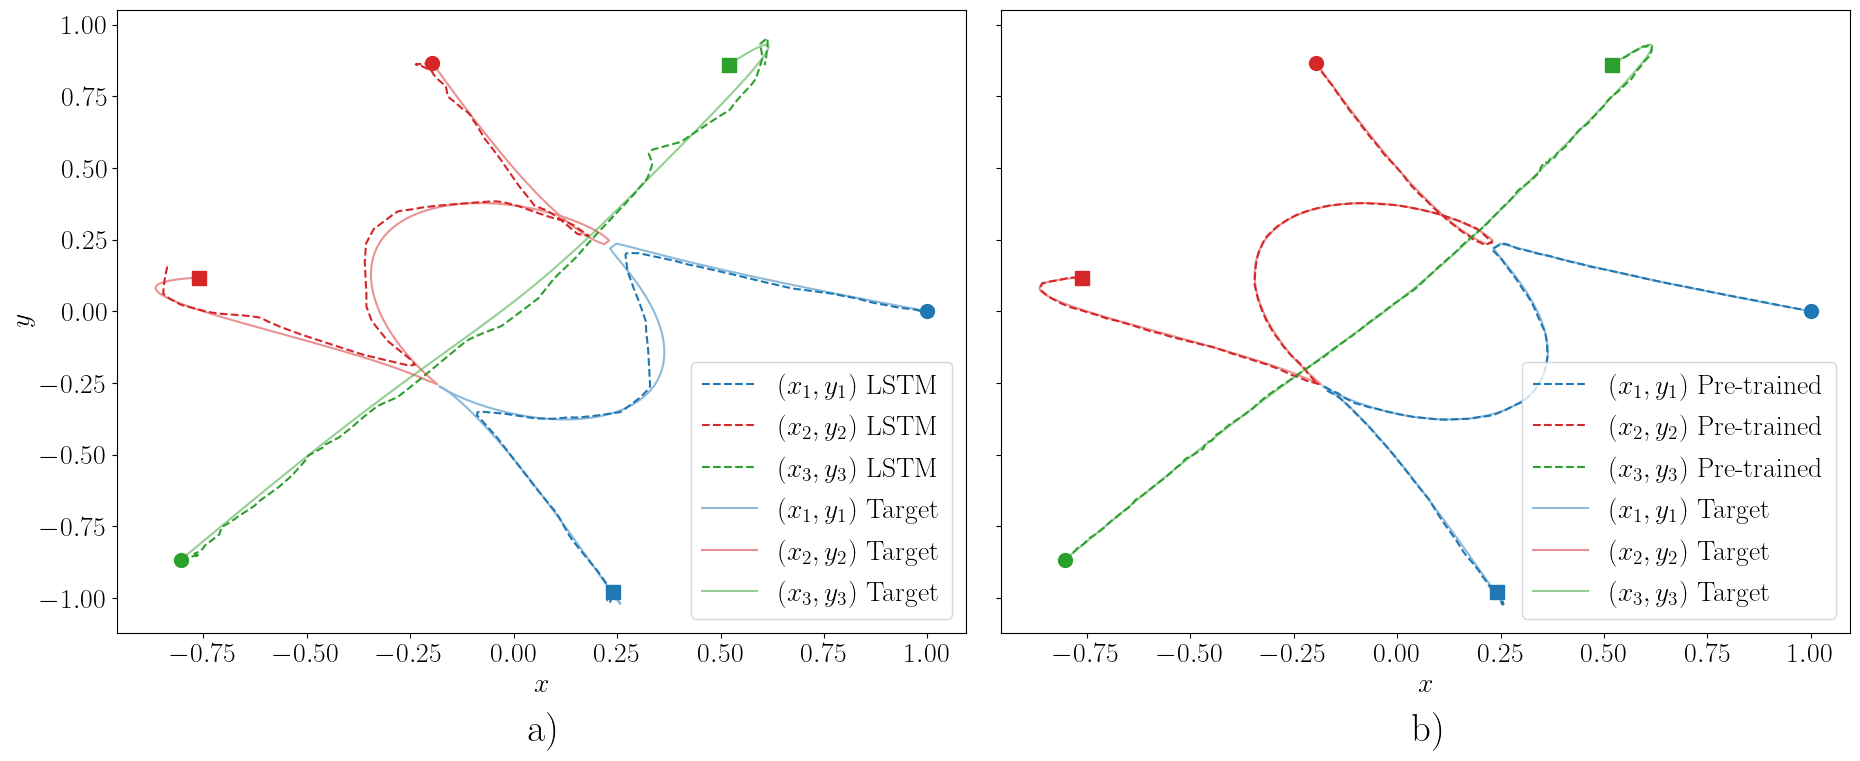

In [19]:
plot_trajectories(traject_lstm,traject_pre, val_targets,
                model = 'LSTM', trajectory_number=tr_num)

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

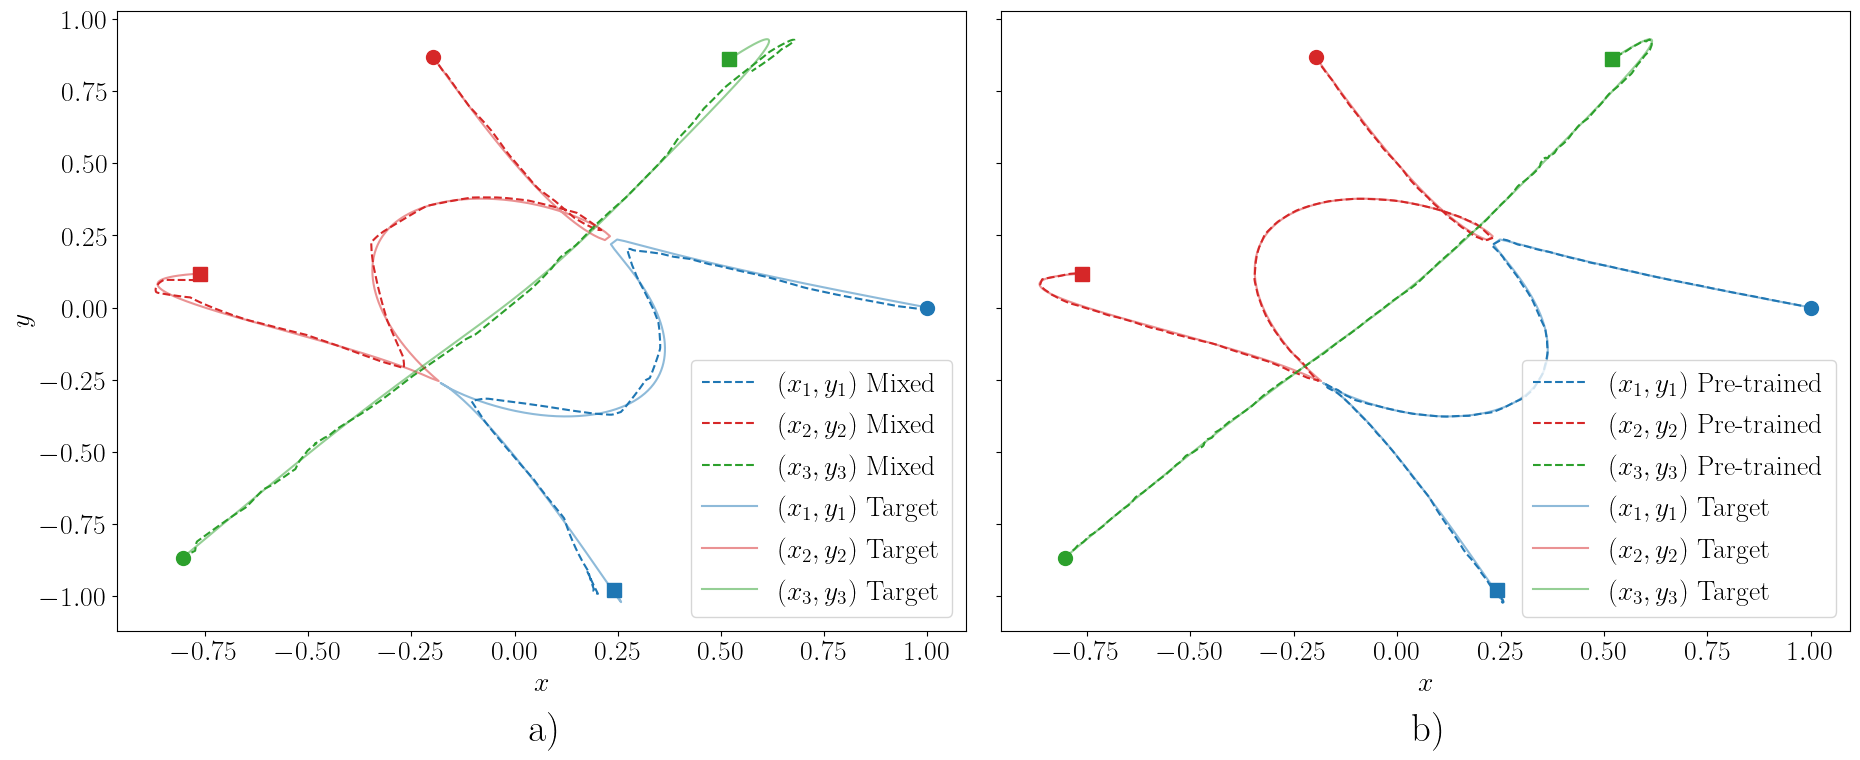

In [126]:
plot_trajectories(traject_mixed,traject_pre, val_targets,
                model = 'Mixed', trajectory_number=tr_num)

## Disturbed initial positions

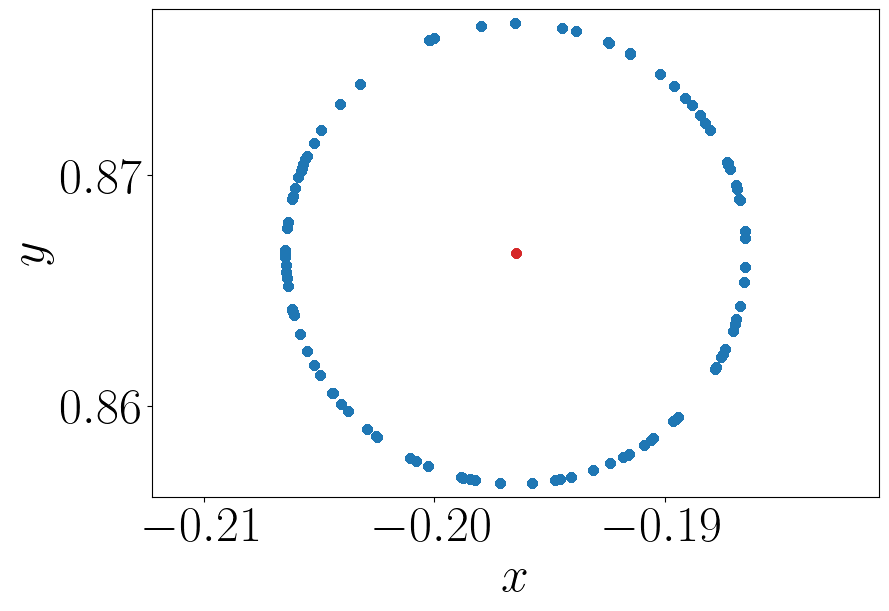

In [28]:
val_dist, val_data_init_true, val_tar_dist = init_dist_data(val_data,tr_num,t_train,val_targets)


plt.figure(figsize=(10,7))
plt.plot(val_dist[:,:,1],val_dist[:,:,2],color='tab:blue',marker='o',linestyle='')
plt.axis('equal')
plt.xlabel('$x$') 
plt.ylabel('$y$')
plt.plot(val_data_init_true[0],val_data_init_true[1],color='tab:red',marker='o',linestyle='')
plt.tight_layout()
#   plt.savefig('disturbed_initial_positions.svg')


In [ ]:
# =========================================================================== #
# Difference between disturbed trajectories and non-disturbed trajectories for all trajectories
# =========================================================================== #

N_traj = np.arange(100)

mean_list_10 = np.zeros((len(N_traj),1000))
mean_list_pre = np.zeros((len(N_traj),1000))

for tr,j in zip(N_traj,range(len(N_traj))):
    val_dist,_,val_tar_dist = init_dist_data(val_data,tr,t_train,val_targets)
    traject_dist = prediction(model_10_dense,val_tar_dist,val_dist)
    traject_dist_pre = prediction(pre_trained_model,val_tar_dist,val_dist)
    
    _,p2_dist,_ = get_trajectories(traject_dist,None)
    _,p2_pre_dist,_ = get_trajectories(traject_dist_pre,None)
    _,p2_non_dist,_ = get_trajectories(traject_10_dense,tr)
    _,p2_pre_non_dist,_ = get_trajectories(traject_pre,tr)
    delta_0 = 0.01
    T = np.linspace(0,1000,1000)
    delta_end_10_list = np.zeros((100,1000))
    delta_end_pre_list = np.zeros((100,1000))
    for i in range(100):
        delta_end_10_x = np.abs(p2_dist[i,:,0] - p2_non_dist[0,:,0])
        delta_end_10_y = np.abs(p2_dist[i,:,1] - p2_non_dist[0,:,1])
        delta_end_10 = np.sqrt(delta_end_10_x**2 + delta_end_10_y**2)
        delta_end_10_list[i] = delta_end_10.flatten()
        

        delta_end_pre_x = np.abs(p2_pre_dist[i,:,0] - p2_pre_non_dist[0,:,0])
        delta_end_pre_y = np.abs(p2_pre_dist[i,:,1] - p2_pre_non_dist[0,:,1])
        delta_end_pre = np.sqrt(delta_end_pre_x**2 + delta_end_pre_y**2)
        delta_end_pre_list[i] = delta_end_pre.flatten()

    mean_list_10[j] = np.mean(delta_end_10_list,axis=0)
    mean_list_pre[j] = np.mean(delta_end_pre_list,axis=0)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


(0.0, 0.3)

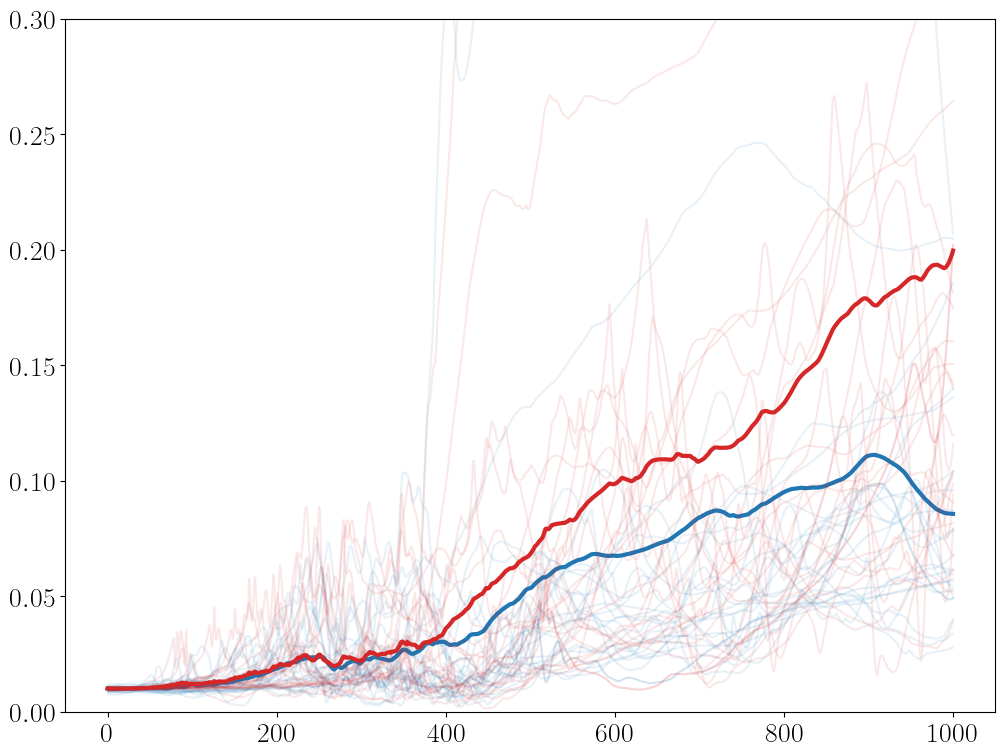

In [274]:

plt.figure(figsize=(12,9))
plt.plot(T,mean_list_10.T,color='tab:blue',alpha=0.1)
plt.plot(T,np.mean(mean_list_10,axis=0),color='tab:blue',label='Dense_10',lw = 3)
plt.plot(T,mean_list_pre.T,color='tab:red',alpha=0.1)
plt.plot(T,np.mean(mean_list_pre,axis=0),color='tab:red',label='Pre-trained',lw = 3)

plt.ylim([0,0.3])


In [29]:
# Chosen trajectory
tr_num = 2


val_dist,_,val_tar_dist = init_dist_data(val_data,tr_num,t_train,val_targets)
traject_dist = prediction(model_10_dense,val_tar_dist,val_dist)
traject_dist_pre = prediction(pre_trained_model,val_tar_dist,val_dist)

# Get the trajectories
_,p2_non_dist,_ = get_trajectories(traject_10_dense,tr_num)
_,p2_dist,_ = get_trajectories(traject_dist,None)
_,p2_pre_non_dist,_ = get_trajectories(traject_pre,tr_num)
_,p2_pre_dist,_ = get_trajectories(traject_dist_pre,None)


## Comparing predictions with and without disturbed initial positions

The predicted trajectories with disturbed initial conditions was compared to the predicted trajectory with non-disturbed initial conditions by evaluating the mean difference.

Lyapunov exponent at the last point for dense_10 0.0083
Lyapunov exponent at the last point for pre-trained0.0076


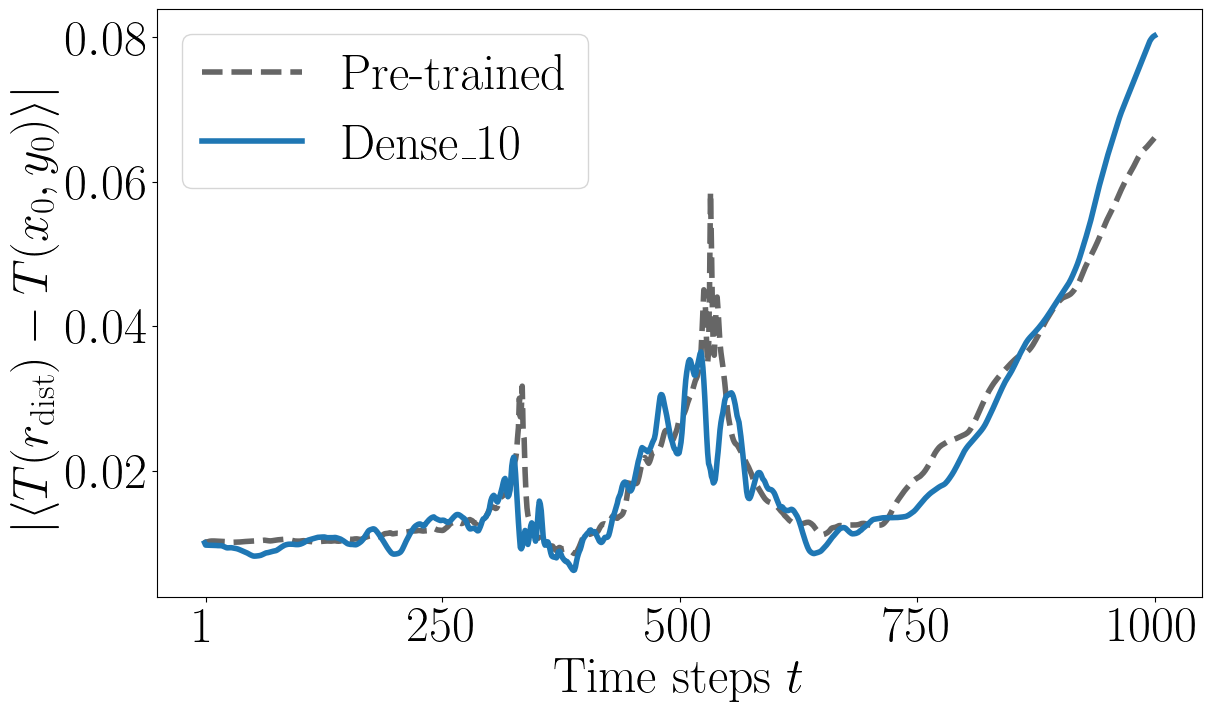

In [39]:
delta_0 = 0.01
T = np.linspace(0,1000,1000)
delta_end_10_list = np.zeros((100,1000))
delta_end_pre_list = np.zeros((100,1000))
for i in range(100):
    delta_end_10_x = np.abs(p2_dist[i,:,0] - p2_non_dist[0,:,0])
    delta_end_10_y = np.abs(p2_dist[i,:,1] - p2_non_dist[0,:,1])
    delta_end_10 = np.sqrt(delta_end_10_x**2 + delta_end_10_y**2)
    delta_end_10_list[i] = delta_end_10.flatten()
    

    delta_end_pre_x = np.abs(p2_pre_dist[i,:,0] - p2_pre_non_dist[0,:,0])
    delta_end_pre_y = np.abs(p2_pre_dist[i,:,1] - p2_pre_non_dist[0,:,1])
    delta_end_pre = np.sqrt(delta_end_pre_x**2 + delta_end_pre_y**2)
    delta_end_pre_list[i] = delta_end_pre.flatten()


delta_end_10_list = np.array(delta_end_10_list)

mean_10 = np.mean(delta_end_10_list,axis=0)
mean_pre = np.mean(delta_end_pre_list,axis=0)

time_lya = [1,250,500,750,1000]

plt.figure(figsize=(13,8))


lya_exp_10 = np.log(mean_10[time_lya[1:]- np.ones_like(time_lya[1:])]/delta_0)/(250)
lya_exp_pre = np.log(mean_pre[time_lya[1:]- np.ones_like(time_lya[1:])]/delta_0)/(250)

print(f'Lyapunov exponent at the last point for dense_10 {lya_exp_10[-1]:.4f}')
print(f'Lyapunov exponent at the last point for pre-trained{lya_exp_pre[-1]:.4f}')

plt.plot(T,mean_pre,c='k',label='Pre-trained',lw = 4,alpha = 0.6,ls = '--')
plt.plot(T,mean_10,c='tab:blue',label='Dense_10',lw = 4)

plt.xlabel('Time steps $t$')
plt.ylabel('$|\\langle T(r_\\mathrm{dist}) - T(x_0,y_0)\\rangle|$')
plt.xticks(time_lya)


plt.legend()
plt.tight_layout()

plt.savefig('Mean distance.pdf')

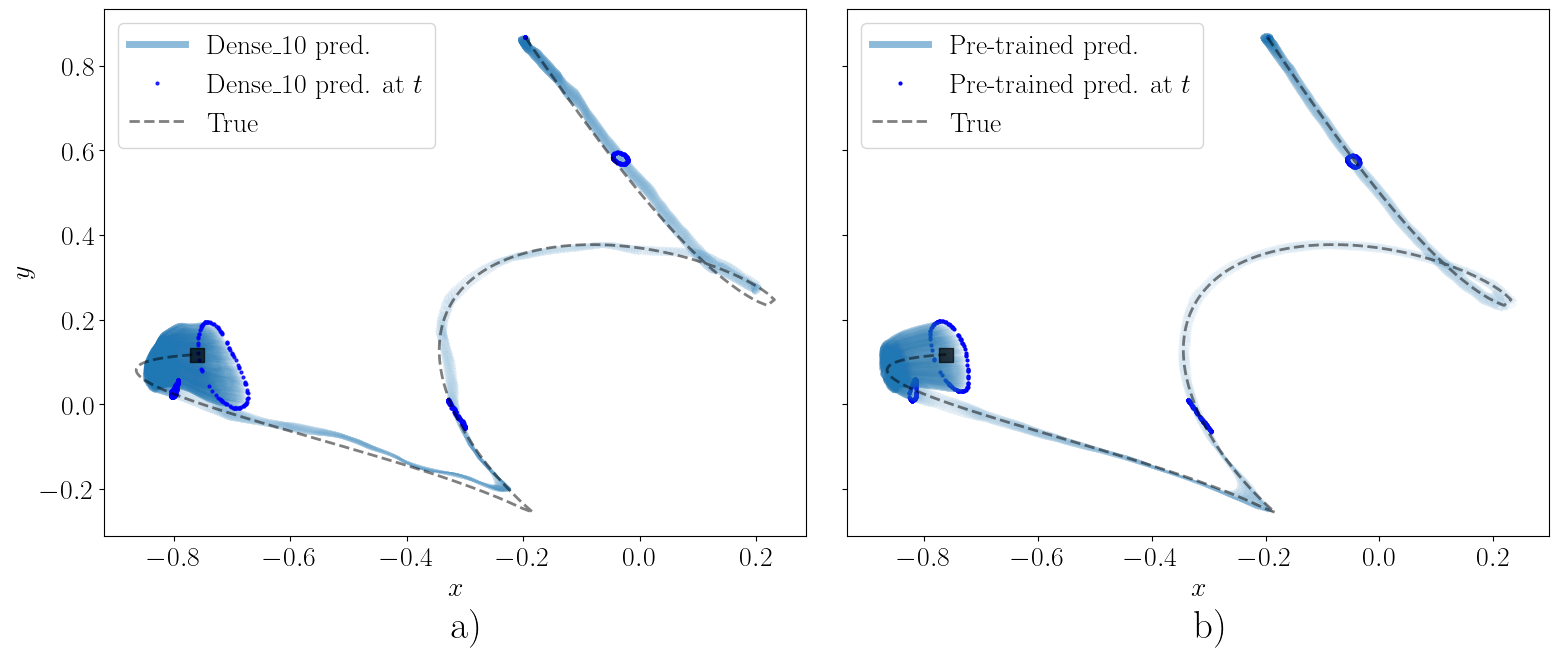

In [39]:
# =========================================================================== #
# Disturbed trajectories at specific time steps
dist_plotter(val_tar_dist,traject_dist,traject_dist_pre,save_disturbed = True)

## Extra Task


In [900]:
# ============================================================================= #
# Extra Task
# ============================================================================= #

import tensorflow as tf
from tensorflow import keras

@tf.function()
def tf_ediff1d(a):
    """
    TensorFlow equivalent of 1D difference.
    
    Args:
        a (array): A TensorFlow array of dimension (N, 1)
        
    Returns:
        diff (array): An array which gives the difference of successive elements of a.
    """
    
    return a[1:] - a[:-1]

@tf.function()
def tf_compute_velocities(t, p):
    """
    Computes the velocities of the particles from the trajectories starting from rest.
    
    Args:
        t (array[float]): An array of shape (N, 1) giving time steps.
        p (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns give the coordinates
                   of the particle.
                             
    Returns:
        v (array): An array of dimension (N, 2) where N is the number 
                   of time steps and the two columns for each array give 
                   the x and y components for the instantaneous velocity
                   of the particle.
    """
    
    # Use the tf_ediff1d function to compute the time differences
    dt = tf_ediff1d(t)
    # Dimension to reshape the arrays
    dim = dt.shape[0]
    # Compute the position differences
    dp_1 = tf.reshape(tf_ediff1d(p[:,0]), [dim, 1])
    dp_2 = tf.reshape(tf_ediff1d(p[:,1]), [dim, 1])
    # Compute the velocities
    v_1 = dp_1/dt
    v_2 = dp_2/dt

    # Add initial velocity 0
    v_1_tot = tf.concat([[[0.]], v_1], axis=0)
    v_2_tot = tf.concat([[[0.]], v_2], axis=0)

    return tf.concat([v_1_tot, v_2_tot], axis=1)

@tf.function()
def tf_compute_kinetic_energy(v):
    """
    Computes the kinetic energy for the given velocity vectors
    
    Args:
        v (array): A (N,2) array of veolcities for N time steps.
        
    Returns:
        ke (array): An array of shape (N, 1) giving the kinetic energies at each time step.
    """
    
    # Use m=1
    return 0.5 * tf.reduce_sum(v**2, axis=1)

@tf.function()
def tf_compute_potential_energy(p1, p2, p3):
    """
    Computes the potential energy for the given position vectors. The value of the 
    gravitational constant is taken as 1 (G=1). The masses are the same value (m=1)
    
    Args:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
                             
    Returns
        pe (array): An array of shape(N, 1) giving the potential energy at each time step
        
    """
    
    # Gravitational constant and mass
    G = 1.0
    m = 1.0
    
    # Compute the distances between the particles
    r12 = tf.norm(p1 - p2, axis=1)
    r13 = tf.norm(p1 - p3, axis=1)
    r23 = tf.norm(p2 - p3, axis=1)
    
    # Compute the potential energy
    pe = -G * m**2 * (1/r12 + 1/r13 + 1/r23)
    
    return pe


In [902]:
# ============================================================================= #
# Custom Loss Function
# ============================================================================= #

# Suggested structure of the custom loss function
tlist = tf.convert_to_tensor(train_data[0,:,0].reshape(-1,1), dtype=tf.float32) # Which will be used in the custom loss

def custom_loss(y, y_pred):
    """
    A custom loss function computing error in energy conservation.

    Args:
        y (array): A (N, 4) array of true positions for N time steps.
        y_pred (array): A (N, 4) array of predicted positions for N time steps.
    
    Returns:
        loss (float): The custom loss value.
    """

    # Extract the training positions of the particles
    p1 = y[:, :2]
    p2 = y[:, 2:]
    p3 = -p1 - p2

    # Extract the predicted positions of the particles
    p1_pred = y_pred[:, :2]
    p2_pred = y_pred[:, 2:]
    p3_pred = -p1_pred - p2_pred

    # Compute the predicted velocities
    predicted_velocities = tf.concat([tf_compute_velocities(tlist, p1_pred),
                                        tf_compute_velocities(tlist, p2_pred),
                                        tf_compute_velocities(tlist, p3_pred)], axis=1) # Obtained from predicted_positions, tlist

    # Compute the initial potential energy according to the true positions
    initial_potential_energy = tf_compute_potential_energy(tf.reshape(p1[0], [1,-1]), tf.reshape(p2[0], [1,-1]), tf.reshape(p3[0], [1,-1])) # Obtained from positions (y)

    # Compute the predicted kinetic and potential energies
    ke_predicted_trajectory = tf_compute_kinetic_energy(predicted_velocities) # Obtained from predicted_velocities
    pe_predicted_trajectory = tf_compute_potential_energy(p1_pred, p2_pred, p3_pred) # Obtained from predicted_positions

    # Compute the error in energy conservation
    error = (ke_predicted_trajectory + pe_predicted_trajectory -
                 initial_potential_energy)

    # Compute the mean of the absolute error of the energy conservation
    energy_loss = tf.reduce_mean(tf.abs(error))
    # Remove large values
    tf.clip_by_value(energy_loss, -1e6, 1e6)
    # The relative weight of the two terms in the custom loss might be tuned.
    return tf.keras.losses.MeanAbsoluteError()(y, y_pred) + 0.005*energy_loss


In [903]:
# Use batches of one trajectory and make datasets
batch_size_train = int(1e3)
batch_size_val = int(1e3)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.reshape(-1,3), train_targets.reshape(-1,4))).batch(batch_size_train)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data.reshape(-1,3), val_targets.reshape(-1,4))).batch(batch_size_val)

# Train the Dense-10 with custom loss
history_10_energy, model_10_energy, t_10_energy = training_models(model_10_Dense, epochs, train_dataset, val_dataset, earlystop=True, loss_function=custom_loss)

Epoch 1/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 152s 21ms/step - loss: 0.3344 - mean_absolute_error: 0.3202 - val_loss: 0.2197 - val_mean_absolute_error: 0.2127
Epoch 2/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 139s 20ms/step - loss: 0.2213 - mean_absolute_error: 0.2147 - val_loss: 0.1778 - val_mean_absolute_error: 0.1702
Epoch 3/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - loss: 0.2001 - mean_absolute_error: 0.1934 - val_loss: 0.1659 - val_mean_absolute_error: 0.1600
Epoch 4/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 153s 22ms/step - loss: 0.1827 - mean_absolute_error: 0.1766 - val_loss: 0.1640 - val_mean_absolute_error: 0.1575
Epoch 5/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 147s 21ms/step - loss: 0.1758 - mean_absolute_error: 0.1696 - val_loss: 0.1478 - val_mean_absolute_error: 0.1421
Epoch 6/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 151s 22ms/step - loss: 0.1659 - mean_absolute_error: 0.1597 - val_loss: 0.1561 - val_mean_absolute_error: 0.1507
Epoch 7/200
6860/6860 ━━━━━━━━━━━━━━━━━━━━ 158s 23ms/step - loss

763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0981 - mean_absolute_error: 0.0933
Loss: [0.10001792758703232, 0.09505116194486618]


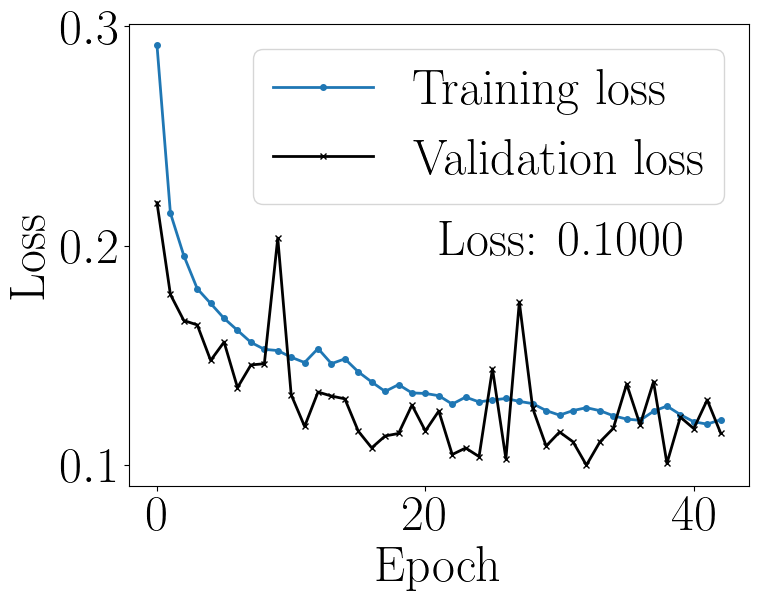

In [904]:
# Plot the training curves and save the model and its training history
loss = model_10_energy.evaluate(val_dataset)
save_model(model_10_energy,'model_energy005')
print(f'Loss: {loss}')

import pickle
with open('models/trainHistoryDict_energy005', 'wb') as file_pi:
    pickle.dump(history_10_energy.history, file_pi)

plot_history(history_10_energy, 'model_energy005', loss, save_training_curves = False)


In [912]:
# =========================================================================== #
# Load and predict the energy and pre-trained model
# =========================================================================== #

model_10_energy_001 = keras.models.load_model('models/model_energy.keras', custom_objects={'custom_loss': custom_loss})
traject_energy_001 = prediction(model_10_energy_001, val_targets, val_data)


In [913]:
model_10_energy_005 = keras.models.load_model('models/model_energy005.keras', custom_objects={'custom_loss': custom_loss})
traject_energy_005 = prediction(model_10_energy_005, val_targets, val_data)

In [921]:
model_10_energy_01 = keras.models.load_model('models/model_energy2.keras', custom_objects={'custom_loss': custom_loss})
traject_energy_01 = prediction(model_10_energy_01, val_targets, val_data)

In [952]:
model_10 = keras.models.load_model('models/model_10_Dense.keras')
traject_10 = prediction(model_10, val_targets, val_data)

I0000 00:00:1730023782.639068 8640465 service.cc:145] XLA service 0x7f8552dbeb90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730023782.640707 8640465 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-10-27 11:09:42.649780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 11:09:42.844137: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730023783.869740 8640465 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [657]:
# Predict the pre-trained model
traject_energy_pre = prediction(pre_trained_model, val_targets, val_data)

array([<Axes: xlabel='$x$', ylabel='$y$'>, <Axes: xlabel='$x$'>],
      dtype=object)

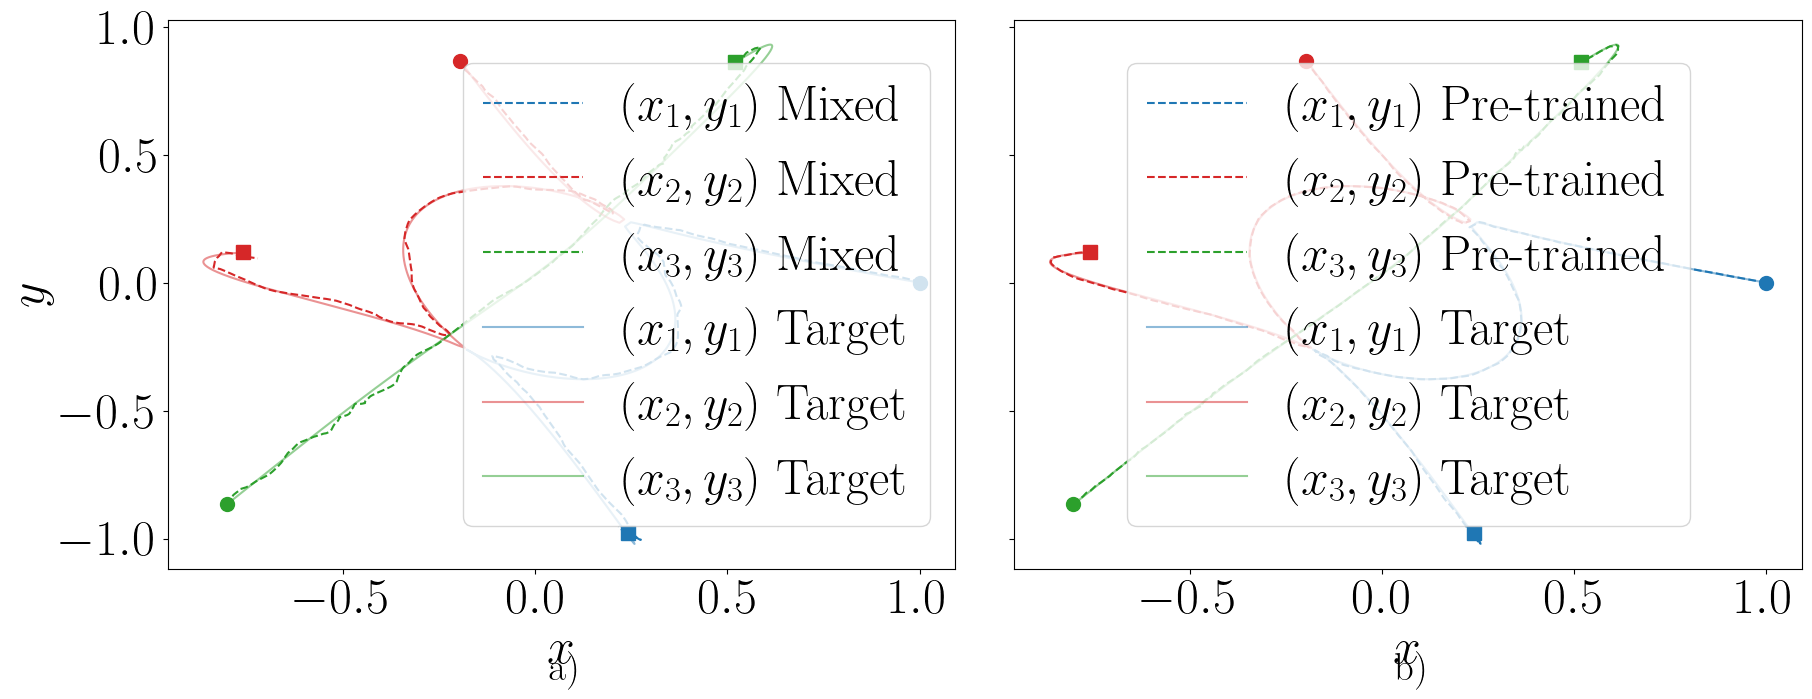

In [957]:
def get_energy_errors(traject, t, traject_data, traject_non_energy):
    '''
    Function to compute the energy errors for the different models.

    Args:
        traject: Trajectory number,
        t: Time steps,
        traject_data: Trajectory data for the model trained with energy conservation,
        traject_non_energy: Trajectory data for the model trained without energy conservation.
    
    Returns:
        energy_error_brutus: Energy error for the Brutus model,
        rel_energy_error_brutus: Relative energy error for the Brutus model,
        energy_error_pre: Energy error for the pre-trained model,
        rel_energy_error_pre: Relative energy error for the pre-trained model,
        energy_error_no: Energy error for the model trained without energy conservation,
        rel_energy_error: Relative energy error for the model trained with energy conservation.
    '''

    # Brutus
    N = data.shape[0]
    # The brutus data here is essentially the validation data
    brutus_data = data[-int(N*0.1)-1:, :, :]

    # Positions
    brutus_p1 = brutus_data[traject, :, 1:3]
    brutus_p2 = brutus_data[traject, :, 3:5]
    brutus_p3 = -brutus_p1 - brutus_p2

    # Velocities
    brutus_v1 = brutus_data[traject, :, 5:7]
    brutus_v2 = brutus_data[traject, :, 7:9]
    brutus_v3 = tf_compute_velocities(t, brutus_p3)

    # Initial energy is the potential energy at the first time step
    init_energy = tf_compute_potential_energy(brutus_p1[0].reshape(1,-1), brutus_p2[0].reshape(1,-1), brutus_p3[0].reshape(1,-1))
    # Compute the kinetic and potential energies
    ke_brutus = tf_compute_kinetic_energy(brutus_v1) + tf_compute_kinetic_energy(brutus_v2) + tf_compute_kinetic_energy(brutus_v3)
    pe_brutus = tf_compute_potential_energy(brutus_p1, brutus_p2, brutus_p3)

    # Compute the total energy, energy error and relative energy error
    energy_brutus = ke_brutus + pe_brutus
    energy_error_brutus = energy_brutus - init_energy
    rel_energy_error_brutus = energy_error_brutus / init_energy

    # Pre-trained model same procedure as above
    p1_pre = traject_energy_pre[:,:,0:2]
    p2_pre = traject_energy_pre[:,:,2:4]
    p3_pre = -p1_pre - p2_pre

    init_energy = tf_compute_potential_energy(p1_pre[traject, 0].reshape(1,-1), p2_pre[traject, 0].reshape(1,-1), p3_pre[traject, 0].reshape(1,-1))
    ke_pre = tf_compute_kinetic_energy(tf_compute_velocities(t, p1_pre[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p2_pre[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p3_pre[traject]))
    pe_pre = tf_compute_potential_energy(p1_pre[traject], p2_pre[traject], p3_pre[traject])

    energy_pre = ke_pre + pe_pre
    energy_error_pre = energy_pre - init_energy
    rel_energy_error_pre = energy_error_pre / init_energy

    # Our ANN without Energy training, same procedure as above
    p1_noE = traject_non_energy[:,:,0:2]
    p2_noE = traject_non_energy[:,:,2:4]
    p3_noE = -p1_noE - p2_noE

    init_energy = tf_compute_potential_energy(p1_noE[traject, 0].reshape(1,-1), p2_noE[traject, 0].reshape(1,-1), p3_noE[traject, 0].reshape(1,-1))
    ke_noE = tf_compute_kinetic_energy(tf_compute_velocities(t, p1_noE[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p2_noE[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p3_noE[traject]))
    pe_noE = tf_compute_potential_energy(p1_noE[traject], p2_noE[traject], p3_noE[traject])

    energy_no = ke_noE + pe_noE
    energy_error_no = energy_no - init_energy

    # Our ANN with Energy training, same procedure as above
    p1 = traject_data[:,:,0:2]
    p2 = traject_data[:,:,2:4]
    p3 = -p1 - p2

    init_energy = tf_compute_potential_energy(p1[traject, 0].reshape(1,-1), p2[traject, 0].reshape(1,-1), p3[traject, 0].reshape(1,-1))
    ke = tf_compute_kinetic_energy(tf_compute_velocities(t, p1[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p2[traject])) + tf_compute_kinetic_energy(tf_compute_velocities(t, p3[traject]))
    pe = tf_compute_potential_energy(p1[traject], p2[traject], p3[traject])

    energy = ke + pe
    energy_error = energy - init_energy 
    rel_energy_error = energy_error / init_energy

    return energy_error_brutus, rel_energy_error_brutus, energy_error_pre, rel_energy_error_pre, energy_error_no, rel_energy_error

# Plot the trajectories
# plot_trajectories(traject_10,traject_pre, val_targets,
#                 model = 'Mixed', trajectory_number=2)

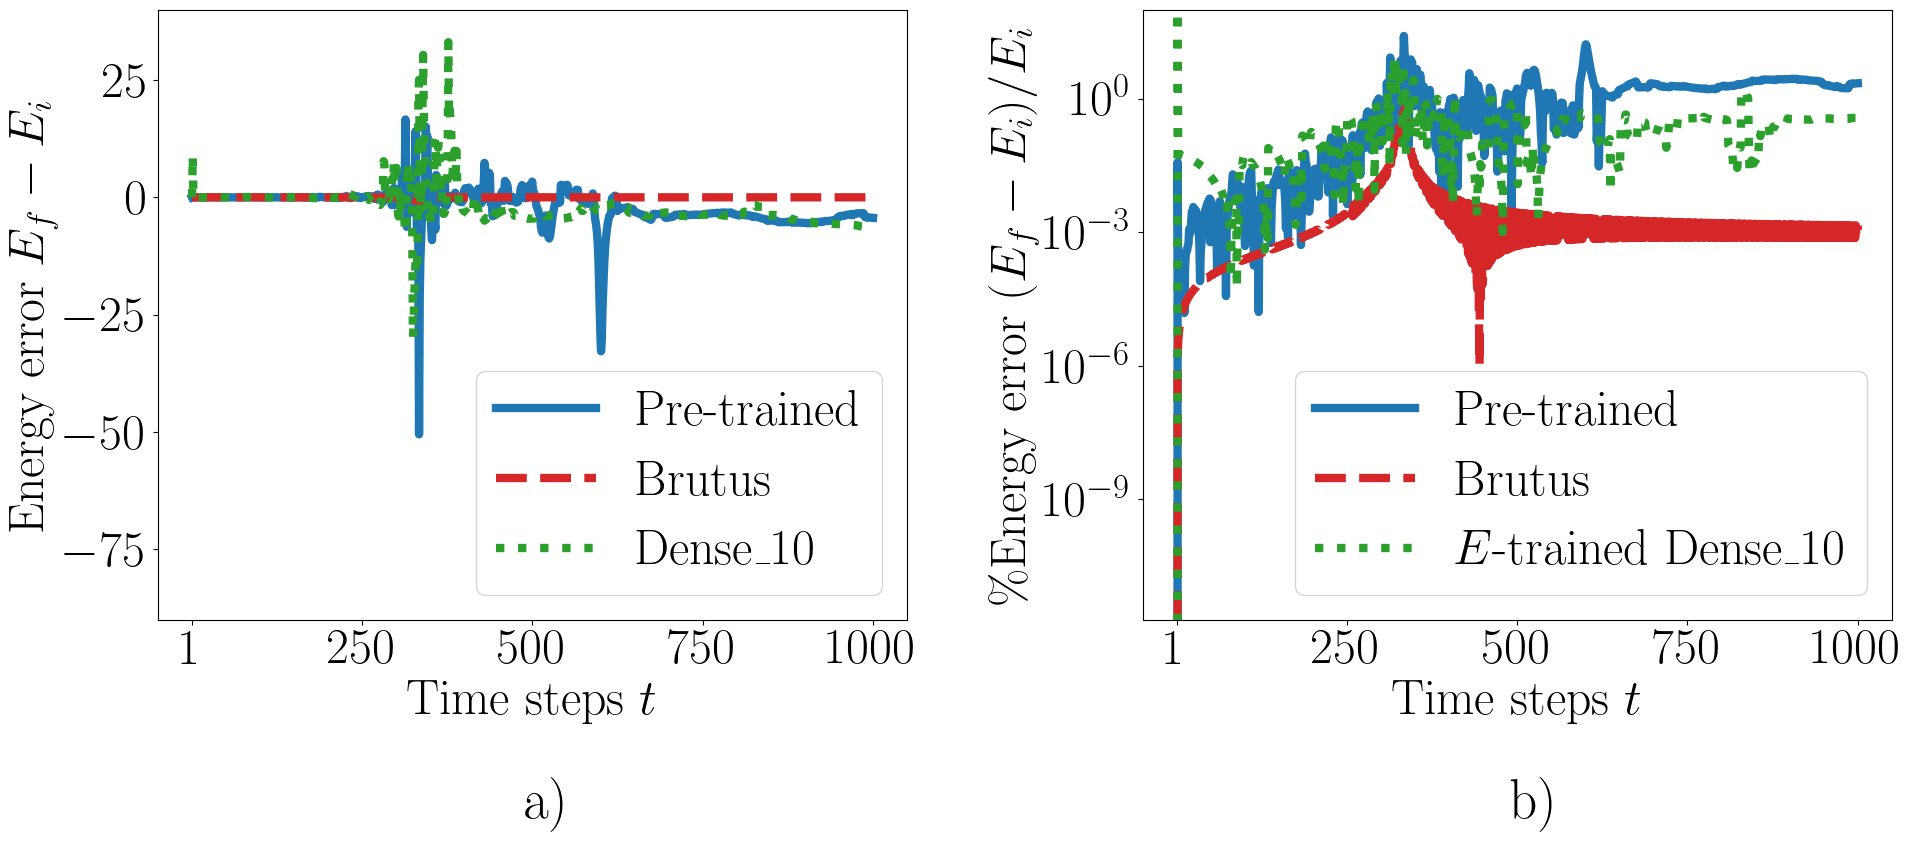

In [993]:
t = train_data[0,:,0].reshape(-1,1)
traject = 119
energy_error_brutus, rel_energy_error_brutus, energy_error_pre, rel_energy_error_pre, energy_error, rel_energy_error = get_energy_errors(traject, t, traject_energy_01, traject_10)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(np.arange(1, 1001), energy_error_pre, '-', label='Pre-trained', color='tab:blue', lw=6)
axs[0].plot(np.arange(1, 1001), energy_error_brutus, '--', label='Brutus', color='tab:red', lw=6)
axs[0].plot(np.arange(1, 1001), energy_error, ':', label='Dense_10', color='tab:green', lw=6)
axs[0].set_xlabel('Time steps $t$')
axs[0].set_xticks([1, 250, 500, 750, 1000])
axs[0].set_ylabel('Energy error $E_f - E_i$')
axs[0].legend(loc='lower right')
axs[0].set_ylim(-90, 40)
plt.tight_layout()

axs[1].semilogy(np.arange(1, 1001), np.abs(rel_energy_error_pre), '-', label='Pre-trained', color='tab:blue', lw=6)
axs[1].semilogy(np.arange(1, 1001), np.abs(rel_energy_error_brutus), '--', label='Brutus', color='tab:red', lw=6)
axs[1].semilogy(np.arange(1, 1001), np.abs(rel_energy_error), ':', label='$E$-trained Dense_10', color='tab:green', lw=6)
axs[1].set_xlabel('Time steps $t$')
axs[1].set_ylabel('\\%Energy error $(E_f - E_i)/E_i$')
axs[1].set_xticks([1, 250, 500, 750, 1000])
axs[1].legend(loc='lower right')
axs[1].set_ylim(0.2e-11, 1e2)

axs[0].text(490,-132.3,'a)',fontsize = 40)
axs[1].text(490,7e-17,'b)',fontsize = 40)

plt.tight_layout()
plt.show()

fig.savefig('Energy_error.pdf')


In [ ]:
# =========================================================================== #
# Model Tuning
# =========================================================================== #

import keras_tuner

# The chosen optimization
from keras_tuner.tuners import BayesianOptimization

def build_model_MyModel(hp):
  model_tuned = keras.Sequential([
    # First LSTM Layer
    keras.layers.Dense(units=64,activation='relu',input_shape=(3,)),
    keras.layers.Dense(units=64,activation='relu'),
    keras.layers.Dense(units=64,activation='relu'),

    keras.layers.Dense(4)
  ])
  model_tuned.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-5,1e-4,1e-3,1e-2,0.1,0.5])),
              loss = tf.losses.MeanAbsoluteError(),
              #loss=hp.Choice('loss_function',[loss_f for loss_f in loss.values()]),
              metrics=['mean_absolute_error'])

  return model_tuned

In [ ]:
MAX_TRIALS = 10            # This was set a bit lower just to ensure that running times were kept low  
EXECUTION_PER_TRIAL = 2 

class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)
  

tuner = MyTuner(
    build_model_MyModel,
    max_trials=MAX_TRIALS,
    objective='val_loss',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, 
    project_name='Tuning_5_Dense')

In [ ]:
tune = False

if tune:
    # Epochs per tune
    noepochauto = 6  
    
    tuner.search(train_dataset, epochs=noepochauto, validation_data=val_dataset)

In [ ]:
# Find the model with the best hyperparameters
model = tuner.get_best_models(num_models=1)[0]

# Print the hyperparameters from the best model
vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()